# Semantic interpretation.

Semantic interpretation is a NLP technique to draw the meaning of a text/sentence. In this implementation, we will focuse on determining two sentences in different languages (english and spanish) have the same meaning.

Some possible sentences for our dataset are:

- Woman buys new car & Mujer compra coche nuevo (1)
- Man buys blue car & Mujer compra coche azul (0)
- Woman buys new car & Mujer compra automóvil nuevo (1)
- Man buys new car & Hombre compra automóvil viejo (0)
- Woman buys old car & Mujer adquiere coche viejo (1)
- Woman buys new car & Mujer hurta coche nuevo (0)
- Woman buys new car & Mujer roba coche rojo (0)
- Woman steals red car & Mujer roba coche rojo (0)
...

Where each example follows this structure: Sentence in english & Sentence in spanish (meaning coincidence label).

Our dataset is built using this vocabulary:


| Subject | Verbs | Objects | Adjectives | | Nombres | Verbos | Objetos | Adjetivos |
| --- | --- | --- | --- | | --- | --- | --- | --- |
| Woman | steals | car | old | | Mujer | roba | coche | viejo |
| Man | buys | sofa | new | | Hombre | hurta | automóvil | nuevo |
|  | purchases | coach | red | |  | compra | sillón | rojo |
|  | breaks | notebook | blue | |  | rompe | cuaderno | azul |


The proposed vocabulary has 14 words and two different kind of sentences for each language:
- Subject + Verb + Object (32 sentences)
- Subject + Verb + (Adj +) Object (128 sentences)

This makes 160 sentences per language and hence 25600 possible combinations.

Or without synonyms:

| Subject | Verbs | Objects | Adjectives | | Nombres | Verbos | Objetos | Adjetivos |
| --- | --- | --- | --- | | --- | --- | --- | --- |
| Woman | steals | car | old | | Mujer | roba | coche | viejo |
| Man | buys | sofa | new | | Hombre | rompe | cuaderno | nuevo |
|  | breaks | notebook | red | |  | compra | sillón | rojo |
|  |  |  | blue | |  |  |  | azul |

## 1. Create dataset

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have three types of words: nouns, adjectives, verbs (transitive). We also distinguish two different types of nouns: objects and subjects. 

In [1]:
import numpy as np
import math
import pickle

##### With synonyms (not used in this notebook)

In [3]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns (subjects)
man, woman = Word('man', n), Word('woman', n)
mujer, hombre = Word('mujer', n), Word('hombre', n)
# nouns (objects)
car, sofa, coach, notebook = Word('car', n), Word('sofa', n), Word('coach', n), Word('notebook', n)
coche, automovil, sillon, cuaderno = Word('coche', n), Word('automovil', n), Word('sillón', n), Word('cuaderno', n)
# adjectives
old, new, red, blue = Word('old', n @ n.l), Word('new', n @ n.l), Word('red', n @ n.l), Word('blue', n @ n.l) 
viejo, nuevo, rojo, azul = Word('viejo', n.r @ n), Word('nuevo', n.r @ n ), Word('rojo', n.r @ n ), Word('blue', n.r @ n )
# Transitive verbs
buys, purchases, steals, breaks  = Word('buys', n.r @ s @ n.l), Word('purchases', n.r @ s @ n.l), Word('steals', n.r @ s @ n.l), Word('breaks', n.r @ s @ n.l)
compra, roba, hurta, rompe  = Word('compra', n.r @ s @ n.l), Word('roba', n.r @ s @ n.l), Word('hurta', n.r @ s @ n.l), Word('rompe', n.r @ s @ n.l)

subjects = [man, woman]
sujetos = [mujer, hombre]
verbs = [buys, purchases, steals, breaks]
verbos = [compra, roba, hurta, rompe]
adjectives = [old, new, red, blue]
adjetivos = [viejo, nuevo, rojo, azul]
objects = [car, sofa, coach, notebook]
objetos = [coche,  sillon, automovil, cuaderno]


vocab_E = subjects + verbs + adjectives + objects 
vocab_S = sujetos + verbos + adjetivos + objetos

##### Without synonyms

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns (subjects)
man, woman = Word('man', n), Word('woman', n)
mujer, hombre = Word('mujer', n), Word('hombre', n)
# nouns (objects)
car, sofa, notebook = Word('car', n), Word('sofa', n), Word('notebook', n)
coche, sillon, cuaderno = Word('coche', n), Word('sillon', n), Word('cuaderno', n)
# adjectives
old, new, red, blue = Word('old', n @ n.l), Word('new', n @ n.l), Word('red', n @ n.l), Word('blue', n @ n.l) 
viejo, nuevo, rojo, azul = Word('viejo', n.r @ n), Word('nuevo', n.r @ n ), Word('rojo', n.r @ n ), Word('azul', n.r @ n )
# Transitive verbs
buys, steals, breaks  = Word('buys', n.r @ s @ n.l),  Word('steals', n.r @ s @ n.l), Word('breaks', n.r @ s @ n.l)
compra, roba, rompe  = Word('compra', n.r @ s @ n.l), Word('roba', n.r @ s @ n.l), Word('rompe', n.r @ s @ n.l)

subjects = [man, woman]
sujetos = [mujer, hombre]
verbs = [buys, steals, breaks]
verbos = [compra, roba, rompe]
adjectives = [old, new, red, blue]
adjetivos = [viejo, nuevo, rojo, azul]
objects = [car, sofa, notebook]
objetos = [coche,  sillon, cuaderno]


vocab_E = subjects + verbs + adjectives + objects 
vocab_S = sujetos + verbos + adjetivos + objetos

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- noun + t. verb + noun



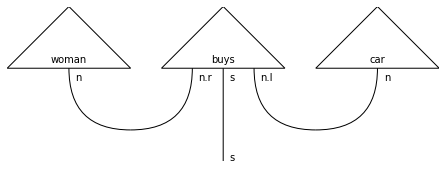

In [3]:
from discopy import Cup, Id, pregroup

grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ buys @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + adjective + noun (for english)

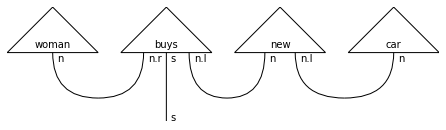

In [4]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n)
sentence = woman @ buys @ new @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + noun +adjective (for spanish)

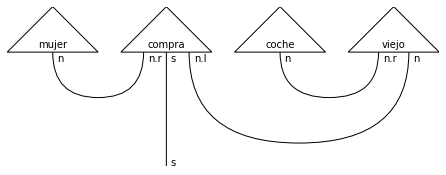

In [5]:
grammar =  Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)
sentence = mujer @ compra @ coche @ viejo >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [6]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'NVN' :  Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'NVAN' : Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n),
    'NVNA' : Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)}                                                                   

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# English noun+verb+noun sentences
parsing_NVNe = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in subjects for verb in verbs for obj in objects}
sentences_NVNe = list(parsing_NVNe.keys())
for sentence in sentences_NVNe:
    diagram = parsing_NVNe[sentence]
    data_psr[sentence] = parsing_NVNe[sentence]
    
# Spanish noun+verb+noun sentences
parsing_NVNs = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in sujetos for verb in verbos for obj in objetos}
sentences_NVNs = list(parsing_NVNs.keys())
for sentence in sentences_NVNs:
    diagram = parsing_NVNs[sentence]
    data_psr[sentence] = parsing_NVNs[sentence]
    
# English noun+verb+adjective+noun sentences
parsing_NVANe = {"{} {} {} {}.".format(subj, verb, adj, obj): subj @ verb @ adj @ obj  >> grammar_dict['NVAN']
            for subj in subjects  for verb in verbs for adj in adjectives for obj in objects}
sentences_NVANe = list(parsing_NVANe.keys())
for sentence in sentences_NVANe:
    diagram = parsing_NVANe[sentence]
    data_psr[sentence] = parsing_NVANe[sentence]
    
# Spanish noun+verb+noun+adjectives sentences
parsing_NVNAs = {"{} {} {} {}.".format(subj, verb, obj, adj): subj @ verb @ obj @ adj  >> grammar_dict['NVNA']
            for subj in sujetos for verb in verbos for obj in objetos  for adj in adjetivos}
sentences_NVNAs = list(parsing_NVNAs.keys())
for sentence in sentences_NVNAs:
    diagram = parsing_NVNAs[sentence]
    data_psr[sentence] = parsing_NVNAs[sentence]

### 1.3. Process the data 

In [14]:
#*****************************************************************************************************
#  Load datasets containing sentences and labels
#*****************************************************************************************************
#Small (20 sentences in english and 20 in spanish; 400 possible combinations)
with open('DataSet_SI_eng_small.txt') as f:
    dataeng_small = f.readlines()
with open('DataSet_SI_spa_small.txt') as f:
    dataspa_small = f.readlines()
with open('TrainingSet_SI_labels_small.txt') as f: 
    train_labels_small = f.readlines() 
with open('TestSet_SI_labels_small.txt') as f: 
    test_labels_small = f.readlines() 
#Medium (65 sentences in english and 65 in spanish; 4225 possible combinations)
with open('DataSet_SI_eng_medium.txt') as f:
    dataeng_medium = f.readlines()
with open('DataSet_SI_spa_medium.txt') as f:
    dataspa_medium = f.readlines()
with open('TrainingSet_SI_labels_medium.txt') as f: 
    train_labels_medium = f.readlines() 
with open('TestSet_SI_labels_medium.txt') as f: 
    test_labels_medium = f.readlines() 
#Big (90 sentences in english and 90 in spanish; 8100 possible combinations)
with open('DataSet_SI_eng_big.txt') as f:
    dataeng_big = f.readlines()
with open('DataSet_SI_spa_big.txt') as f:
    dataspa_big = f.readlines()
with open('TrainingSet_SI_labels_big.txt') as f: 
    train_labels_big = f.readlines() 
with open('TestSet_SI_labels_big.txt') as f: 
    test_labels_big = f.readlines() 

In [15]:
#*****************************************************************************************************
#  Transform senteces into diagrams
#*****************************************************************************************************
#Small
dataeng_psr_dict_small, dataspa_psr_dict_small= {},{}
dict_small=[dataeng_psr_dict_small, dataspa_psr_dict_small]
sent_type_small={}
data_small=[dataeng_small,dataspa_small]
#Medium
dataeng_psr_dict_medium, dataspa_psr_dict_medium = {},{}
dict_medium=[dataeng_psr_dict_medium, dataspa_psr_dict_medium, sent_type_medium]
sent_type_medium={}
data_medium=[dataeng_medium,dataspa_medium]
#Big
dataeng_psr_dict_big, dataspa_psr_dict_big = {},{}
dict_big=[dataeng_psr_dict_big, dataspa_psr_dict_big]
sent_type_big={}
data_big=[dataeng_big,dataspa_big]
################
parsing=[parsing_NVNe,parsing_NVNs,parsing_NVANe,parsing_NVNAs]
types=['NVN','NVN','NVAN','NVNA']
for (datasize,dictsize,sent_type) in zip([data_small,data_medium,data_big],[dict_small,dict_medium,dict_big],
                                            [sent_type_small,sent_type_medium,sent_type_big]): 
    for (data,data_psr_dict)  in zip(datasize,dictsize):
        for sentence in data:
            sentstr = sentence[:-1]
            for (par,typ) in zip(parsing,types):
                if sentstr in list(par.keys()): 
                    diagram = par[sentstr]
                    data_psr_dict[sentstr] = diagram
                    sent_type[sentstr] = typ 

In [16]:
#*****************************************************************************************************
#  Save labels in lists to be used later on
#*****************************************************************************************************
#Training set (To train the paramenters)
train_labelslist_small,train_labelslist_medium,train_labelslist_big=[],[],[]
train_labelslist=[train_labelslist_small,train_labelslist_medium,train_labelslist_big]
trainset_labels=[train_labels_small,train_labels_medium,train_labels_big]
for (labelslist,labelsset) in zip(train_labelslist,trainset_labels):  
    for pair in labelsset:
        label=pair[-2]
        labelslist.append(label)
#Testing set (To test the trained paramenters)
test_labelslist_small,test_labelslist_medium,test_labelslist_big=[],[],[]
test_labelslist=[test_labelslist_small,test_labelslist_medium,test_labelslist_big]
testset_labels=[test_labels_small,test_labels_medium,test_labels_big]
for (labelslist,labelsset) in zip(test_labelslist,testset_labels):  
    for pair in labelsset:
        label=pair[-2]
        labelslist.append(label)

In [17]:
#*****************************************************************************************************
#  Remove resource-consumming cups and transform them into effects (https://github.com/CQCL/qnlp_lorenz_etal_2021_resources)
#*****************************************************************************************************
from discopy import Cap, Box
#Old data with cups
dataeng_psr_dict_sizes=[dataeng_psr_dict_small,dataeng_psr_dict_medium,dataeng_psr_dict_big]
dataspa_psr_dict_sizes=[dataspa_psr_dict_small,dataspa_psr_dict_medium,dataspa_psr_dict_big]
#New data with effects
dataeng_new_psr_dict_small,dataeng_new_psr_dict_medium,dataeng_new_psr_dict_big = {},{},{}
dataspa_new_psr_dict_small,dataspa_new_psr_dict_medium,dataspa_new_psr_dict_big = {},{},{}
dataeng_new_psr_dict_sizes=[dataeng_new_psr_dict_small,dataeng_new_psr_dict_medium,dataeng_new_psr_dict_big]
dataspa_new_psr_dict_sizes=[dataspa_new_psr_dict_small,dataspa_new_psr_dict_medium,dataspa_new_psr_dict_big]
###########
sent_type_size=[sent_type_small,sent_type_medium,sent_type_big]
for (dataeng_new_psr_dict,dataspa_new_psr_dict,
     dataeng_psr_dict,dataspa_psr_dict,sent_type) in zip(dataeng_new_psr_dict_sizes,dataspa_new_psr_dict_sizes,
                                                         dataeng_psr_dict_sizes,dataspa_psr_dict_sizes,sent_type_size):
    for (data_psr_dict,data_new_psr_dict)  in zip([dataeng_psr_dict,dataspa_psr_dict],
                                                  [dataeng_new_psr_dict,dataspa_new_psr_dict]):
        for sentstr in data_psr_dict.keys():
            num_words = len(sentstr.split(' '))
            words = data_psr_dict[sentstr].boxes[:num_words]
            if sent_type[sentstr] == 'NVN':
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[2].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['NVN']
                data_new_psr_dict[sentstr] = sentence.normal_form()
            elif sent_type[sentstr] == 'NVAN':
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[3].name, n.l, Ty())
                words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
                sentence = words_new >> grammar_dict['NVAN']
                data_new_psr_dict[sentstr] = sentence.normal_form()
            elif sent_type[sentstr] == 'NVNA':
                noun1 = Box(words[0].name, n.r, Ty())
                noun2 = Box(words[2].name, n.r, Ty())
                words_new = (Cap(n.r, n) @ Cap(n.r, n)) >> (noun1 @ Id(n) @ words[1] @ noun2 @ Id(n) @ words[3]) 
                sentence = words_new >> grammar_dict['NVNA']
                data_new_psr_dict[sentstr] = sentence.normal_form()

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [19]:
#*****************************************************************************************************
#  Redefine the vocabulary according to the new domain and code nouns as effects.
#*****************************************************************************************************
from discopy import Cap, Box
#English
vocab_psr_E = []
for word in vocab_E:
    if word.cod == Ty('n'):
        vocab_psr_E.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr_E.append(word)
#Spanish
vocab_psr_S = []
for word in vocab_S:
    if word.cod == Ty('n'):
        vocab_psr_S.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr_S.append(word)
vocab_psr=vocab_psr_E+vocab_psr_S

## 2. Create quantum circuit

Once the dataset and its corresponding diagrams are created, the next step is to construct the variational quantum circuits associated with them. In order to do that, we will use different ansätze depending on the type of the word that we want to represent. In this case we only have three types of words, nouns, adjetives and verbs. Nouns will have associated 1 qubit, and sentences two qubits, therefore verbs 4 qubits, and adjetives 2 qubits. Moreover, we will also distinguish between states and effects when constructing the ansätze.

In [20]:
from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.gates import Rx, Rz
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial

q_s = 2 # number of qubits for type s (sentence)
q_n = 1 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz
p_n = 1       # number of parameters for a single-qubit word (noun); valued in {1,2,3}.

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

# Define the ansätze for states and effects

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params) 

def ansatz_state(state, params):  
    arity = sum(ob[Ty(factor.name)] for factor in state.cod)
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    else:
        return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params):  
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    else:
        return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

# Construct the circuit functor
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return Functor(ob_cqmap, ar)

In [39]:
#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i]))))
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [44]:
#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     36


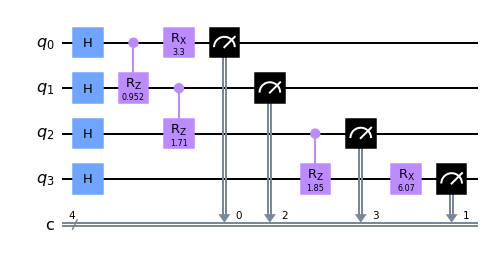

In [75]:
#****************************************
# Transform sentences diagrams into Qiskit Quantum Circuits
#****************************************
from pytket.extensions.qiskit import tk_to_qiskit
from discopy.quantum import Measure

def to_qiskitcircuit(unshaped_params,diagrams_dict): #unshaped_params=parameters to the variationals circuits
                                                     #diagrams_dict=dictionary with the sentences as keys and their diagrams as values
    func = F(reshape_params(unshaped_params, par_shapes))
    circs=[]
    for sentstr in diagrams_dict.keys():
        diagram=diagrams_dict[sentstr]
        circuit=(func(diagram) >> Measure() @ Measure()) #Add the measurements to the circuit
        pytket_circuit = circuit.to_tk()
        qiskit_circuit = tk_to_qiskit(pytket_circuit)   #Create Qiskit Quantum Circuit
        circs.append(qiskit_circuit)
    return circs
########## 
#For example (with random parameters "rand_shaped_pars")

circuits_eng_small,circuits_eng_medium,circuits_eng_big=[],[],[]
circuits_spa_small,circuits_spa_medium,circuits_spa_big=[],[],[]
circuits_eng = [circuits_eng_small,circuits_eng_medium,circuits_eng_big] # list of Qiskit Quantum Crcuits of english sentences 
circuits_spa = [circuits_spa_small,circuits_spa_medium,circuits_spa_big] # list of Qiskit Quantum Circuits of spanish sentences 
for (circ_eng,circ_spa,dataeng_new_psr_dict,dataspa_new_psr_dict) in zip(circuits_eng,circuits_spa,
                                                                         dataeng_new_psr_dict_sizes,dataspa_new_psr_dict_sizes):
    for (circ,data_new_psr_dict)  in zip([circ_eng,circ_spa],
                                                  [dataeng_new_psr_dict,dataspa_new_psr_dict]):
        circ.append(to_qiskitcircuit(rand_unshaped_pars,data_new_psr_dict))

circuits_spa_medium[0][0].draw(output='mpl')

## 4. Optimization functions

In [61]:
from qiskit import BasicAer, execute, Aer, IBMQ
#from qiskit.providers.aer import QasmSimulator

In [86]:
#****************************************
# Functions to perform the hybrid quantum-classical machine learning (optimization of variational parameters) 
#****************************************
####Predict labels (which sentences have the same meaning)
def get_probs(unshaped_params,withshots=True,simulation=True):
    circuits_eng = to_qiskitcircuit(unshaped_params,diagrams_eng)
    circuits_spa = to_qiskitcircuit(unshaped_params,diagrams_spa)
    if withshots:
        if simulation:
            backend=Aer.get_backend('qasm_simulator')
        else:
            ibmq_device='ibmq_athens'
            backend=IBMQ.get_provider(group='main').get_backend(ibmq_device)
        results_eng,results_spa=[],[]
        for (circ_eng,circ_spa) in zip(circuits_eng,circuits_spa):
            results_eng.append(execute(circ_eng, backend=backend).result().get_counts())
            results_spa.append(execute(circ_spa, backend=backend).result().get_counts())
        pred_labels_distrs=[]    
        for countssent_eng in results_eng:
            for countssent_spa in results_spa:
                predlabel=0
                for bits in countssent_eng.keys():
                    if bits in countssent_spa.keys():
                        predlabel+=countssent_eng[bits]*countssent_spa[bits]/max_n_shots**2
                    else:
                        predlabel+=0
            pred_labels_distrs.append(abs(predlabel - 1e-9))
        maxlabel=max(pred_labels_distrs)
        pred_labels_distrs_norm=[x/maxlabel for x in pred_labels_distrs]       
    elif simulation:
        backend=Aer.get_backend('statevector_simulator')
        results_eng,results_spa=[],[]
        for (circ_eng,circ_spa) in zip(circuits_eng,circuits_spa):
            results_eng.append(execute(circ_eng, backend=backend).result().get_statevector())
            results_spa.append(execute(circ_spa, backend=backend).result().get_statevector())
        pred_labels_distrs=[]    
        for vectorsent_eng in results_eng:
            for vectorsent_spa in results_spa:
                print(len(vectorsent_eng),len(vectorsent_spa))
                pred_labels_distrs.append(abs(np.vdot(vectorsent_eng,vectorsent_spa)- 1e-9))
        maxlabel=max(pred_labels_distrs)
        pred_labels_distrs_norm=[x/maxlabel for x in pred_labels_distrs]   
    return pred_labels_distrs_norm

####Two possible cost functions for the model (the function that the machine tries to minimize)
def get_cost_crossentropy(pred_labels_distrs):
    cross_entropies = np.array([int(train_labels[s]) * math.log2(pred_labels_distrs[s]) 
                                for s in range(len(train_labels)) if train_labels[s]!='x'])
    return -1 / len([train_labels[s] for s in range(len(train_labels)) if train_labels[s]!='x']) * np.sum(cross_entropies)

def get_cost_absoluteerror(pred_labels_distrs): 
    error = 0
    train_size=0
    for (i, res) in enumerate(pred_labels_distrs):
        if train_labels[i]!='x': 
            train_size+=1
            error+=abs(int(train_labels[i])-res)
    return error * 100 / train_size

####Error functions for the model (a measure of how many sentences the quantum device translates correctly)
def get_train_error(pred_labels_distrs): #percentage of predicted labels equal to actual labels in the training set 
    correct = 0
    train_size=0
    for (i, res) in enumerate(pred_labels_distrs):
        if train_labels[i]!='x': 
            train_size+=1
            pred_result = round(res) #We are taking as 1 (same meaning) when the output is >0.5 and viceversa
            train_result = round(int(train_labels[i])) 
            if train_result == pred_result:
                correct += 1
    return 100 - correct * 100 / train_size

def get_test_error(pred_labels_distrs):  #percentage of predicted labels equal to actual labels in the test set  
    correct = 0
    test_size=0
    for (i, res) in enumerate(pred_labels_distrs):
        if test_labels[i]!='x': 
            test_size+=1
            pred_result = round(res) #We are taking as 1 (same meaning) when the output is >0.5 and viceversa
            test_result = round(int(test_labels[i])) 
            if test_result == pred_result:
                correct += 1
    return 100 - correct * 100 / test_size

####Other useful functions for performing optimization and tracking intermediate results
def objective_function(unshaped_params,costfunction=cost_function): #cost_function=get_cost_crossentropy or 
                                                                    #get_cost_absoluteerror
    #To perform optimization
    pred_labels_distrs=get_probs(unshaped_params,withshots=withshots,simulation=simulation)
    cost=costfunction(pred_labels_distrs)
    #To track the results
    trainerror=get_train_error(pred_labels_distrs)
    testerror=get_test_error(pred_labels_distrs)
    cost_crossentr=get_cost_crossentropy(pred_labels_distrs)
    cost_abserr=get_cost_absoluteerror(pred_labels_distrs)
    tracking=callback(trainerror,testerror,cost_crossentr,cost_abserr)
    return cost  

def callback(trainerror,testerror,cost_crossentr,cost_abserr):
    global error_train_history,error_test_history,cost_crossentropy_history,cost_abserror_history
    error_train_history.append(trainerror)
    error_test_history.append(testerror)
    cost_crossentropy_history.append(cost_crossentr)
    cost_abserror_history.append(cost_abserr)
    print("Cost_AbsErr: {} ,Cost_CrossEntr: {} , ErrorTrain: {}, ErrorTest: {}".format(cost_abserr,cost_crossentr,
                                                                                      trainerror,testerror))

Finally, we can run the optimizer and obtain the results.

In [87]:
#************************************
# Quantum run: training and error calculation
#************************************
from time import time
from qiskit.algorithms.optimizers import COBYLA,SPSA,L_BFGS_B

####Experiment Parameters
n_runs = 1
niter = 100
cost_function=get_cost_absoluteerror #costfunction=get_cost_crossentropy or get_cost_absoluteerror
method='COBYLA' #Classical optimization method= 'COBYLA','SPSA' or'L_BFGS_B'
max_n_shots = 8192  # maximum shots possible
withshots=False
simulation=True
dataset='small' #dataset='small','medium','big'

####Data for the experiment
if dataset=='small':
    #Diagrams
    diagrams_eng = dataeng_new_psr_dict_small
    diagrams_spa = dataspa_new_psr_dict_small 
    #Training and test labels
    train_labels = train_labelslist_small
    test_labels = test_labelslist_small
if dataset=='medium':
    #Diagrams
    diagrams_eng = dataeng_new_psr_dict_medium
    diagrams_spa = dataspa_new_psr_dict_medium 
    #Training and test labels
    train_labels = train_labelslist_medium
    test_labels = test_labelslist_medium
if dataset=='big':
    #Diagrams
    diagrams_eng = dataeng_new_psr_dict_big
    diagrams_spa = dataspa_new_psr_dict_big 
    #Training and test labels
    train_labels = train_labelslist_big
    test_labels = test_labelslist_big
    
####Classical Optimizers (from qiskit.algorithms.optimizers)
if method=='COBYLA':
    optimizer=COBYLA(maxiter=niter)
elif method=='SPSA':
    optimizer=SPSA(maxiter=niter)
elif method=='L_BFGS_B':
    optimizer=L_BFGS_B(maxiter=niter)

####Tracking variables
param_histories = []
error_train_history,error_test_history = [],[]
cost_crossentropy_history,cost_abserror_history = [],[]

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = randparams(par_shapes)
    start = time()
    res = optimizer.optimize(len(rand_unshaped_pars),objective_function,initial_point=rand_unshaped_pars)
    print("Parameters: {} ,CostFunction: {} , NºEvaluations: {}".format(res.point,res.value,res.nfev))
    print('run', i+1, 'done')
    print('Time taken: ', time() - start)

---------------------------------
Start run  1
16 16
16 16
16 16
16 16
16 64


ValueError: cannot reshape array of size 64 into shape (16,)